In [43]:
%load_ext autoreload
%autoreload 2
import numpy
import pandas
import io
import uuid
import psycopg.sql
import pyarrow
import pyarrow.parquet

import jobqueue
from jobqueue.connection_manager import ConnectionManager



import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

import dmp.keras_interface.model_serialization as model_serialization
from dmp.task.experiment.training_experiment.training_epoch import TrainingEpoch

pd.options.display.max_seq_items = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# from enum import Enum, auto

# class ColumnSource(Enum):
#     run_column=auto()
#     run
#     run_column=auto()
#     run_column=auto()
#     run_column=auto()
#     run_column=auto()

from dataclasses import dataclass



@dataclass
class Column:
    name : str
    pandas_type : str


In [ ]:
'''
parent/root runs:
select
	*
from
	run_data d
where
	command @> '{"experiment":{"type":"LTHExperiment"}}'
limit 10
;
'''

In [ ]:
'''
SELECT
	id,
	parent,
	pruning_rate
FROM
(
	SELECT
	  s.id,
      s.parent,
	  (d.command->'experiment'->'pruning'->'method'->>'pruning_rate')::float pruning_rate
	FROM
		run_data d,
		run_status s
	WHERE TRUE
		AND s.id = d.id
		AND d.command @> '{"experiment":{"type":"IterativePruningExperiment"}}'::jsonb
) x
WHERE TRUE
	AND pruning_rate < .5
ORDER BY pruning_rate, parent
;
'''

In [37]:
def flatten_json(json_obj, parent_key='', separator='_'):
    flattened = {}
    for key, value in json_obj.items():
        new_key = f"{parent_key}{separator}{key}" if parent_key else key
        if isinstance(value, dict):
            flattened.update(flatten_json(value, new_key, separator=separator))
        else:
            flattened[new_key] = value
    return flattened


experiment_id = 0
run_command = {}
credentials = jobqueue.load_credentials('dmp')
with ConnectionManager(credentials) as connection:
    with connection.cursor(binary=True) as cursor:
        query = psycopg.sql.SQL("""
SELECT
    d.command,
    h.history history,
    h.experiment_id,
    e.by_epoch
FROM
    run_status s,
    run_data d,
    history h,
    experiment2 e
WHERE TRUE
    AND s.id = 'c1a3792d-c30d-4b55-9ca4-d1bbcc59518c'
    AND d.id = s.id
    AND h.id = s.id
    AND e.experiment_id = h.experiment_id
LIMIT 1;
""")

        cursor.execute(query, binary=True)
        row = cursor.fetchone()
        with io.BytesIO(row[1]) as buffer:
            history = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode='r')).to_pandas()

        run_command = row[0]
        from dmp.marshaling import marshal
        run = marshal.demarshal(run_command)

        flat = flatten_json(row[0])
        for k, v in flat.items():
            if isinstance(v, list):
                continue
            history[k] = v

        experiment_id = row[2]

        with io.BytesIO(row[3]) as buffer:
            by_epoch = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode='r')).to_pandas()


history.describe()
history

/tmp/ipykernel_29509/4106211986.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/tmp/ipykernel_29509/4106211986.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/tmp/ipykernel_29509/4106211986.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[k] = v
/

,test_accuracy,validation_categorical_crossentropy,trainms_ms,trained_categorical_crossentropy,validation_loss,trained_ms,fit_number,trained_accuracy,fit_epoch,retained,train_accuracy,free_parameter_count,train_categorical_crossentropy,test_categorical_crossentropy,train_loss,seed_number,test_ms,validation_accuracy,test_loss,trained_loss,masked_parameter_count,epoch_startms_ms,epoch,run_data_job_id_type,run_data_job_id_label,run_data_job_id_value,run_data_run_id_type,run_data_run_id_label,run_data_run_id_value,run_data_context_num_cpus,run_data_context_num_gpus,run_data_context_queue_id,run_data_context_num_nodes,run_data_context_worker_id_type,run_data_context_worker_id_value,run_data_context_gpu_memory,run_data_context_tensorflow_strategy,run_data_git_hash,run_data_platform,run_data_host_name,run_data_slurm_job_id,run_data_python_version,run_data_tensorflow_version,run_seed,run_type,run_model_saving_type,run_model_saving_fixed_interval,run_model_saving_fixed_threshold,run_model_saving_exponential_rate,run_model_saving_save_initial_model,run_model_saving_save_trained_model,run_record_times,run_rewind_run_id_type,run_rewind_run_id_value,run_resume_checkpoint_type,run_resume_checkpoint_epoch_type,run_resume_checkpoint_epoch_epoch,run_resume_checkpoint_epoch_marker,run_resume_checkpoint_epoch_fit_epoch,run_resume_checkpoint_epoch_fit_number,run_resume_checkpoint_epoch_sequence_number,run_resume_checkpoint_run_id_type,run_resume_checkpoint_run_id_label,run_resume_checkpoint_run_id_value,run_resume_checkpoint_load_mask,run_resume_checkpoint_load_optimizer,run_prune_first_iteration,run_record_post_training_metrics,type,experiment_fit_epochs,experiment_fit_batch_size,experiment_data_lmc,experiment_data_batch,experiment_data_ml_task,experiment_data_model_name,experiment_data_model_family,experiment_data_data_set_size,experiment_data_test_set_size,experiment_data_train_set_size,experiment_data_num_free_parameters,experiment_data_validation_set_size,experiment_loss_class,experiment_type,experiment_model_type,experiment_model_input_name,experiment_model_input_type,experiment_model_output_type,experiment_model_output_units,experiment_model_output_use_bias,experiment_model_output_activation,experiment_model_output_bias_constraint,experiment_model_output_bias_initializer,experiment_model_output_bias_regularizer,experiment_model_output_kernel_constraint,experiment_model_output_kernel_initializer_class,experiment_model_output_kernel_regularizer,experiment_model_output_activity_regularizer,experiment_dataset_name,experiment_dataset_type,experiment_dataset_method,experiment_dataset_source,experiment_dataset_test_split,experiment_dataset_label_noise,experiment_dataset_validation_split,experiment_pruning_type,experiment_pruning_method_type,experiment_pruning_method_pruning_rate,experiment_pruning_new_seed,experiment_pruning_iterations,experiment_pruning_rewind_epoch_type,experiment_pruning_rewind_epoch_epoch,experiment_pruning_rewind_epoch_marker,experiment_pruning_rewind_epoch_fit_epoch,experiment_pruning_rewind_epoch_fit_number,experiment_pruning_rewind_epoch_sequence_number,experiment_pruning_rewind_optimizer,experiment_pruning_max_epochs_per_iteration,experiment_optimizer_class,experiment_optimizer_learning_rate,experiment_precision,experiment_early_stopping_class,experiment_early_stopping_monitor,experiment_early_stopping_patience,experiment_early_stopping_min_delta,experiment_early_stopping_restore_best_weights
0,0.1422,2.999195,NaN,3.008362,2.999195,NaN,0,0.145009,0,True,0.145009,61706,3.008362,3.019955,3.008362,0,NaN,0.151429,3.019955,3.008362,4,NaN,0,UUID,1b,c1a3792d-c30d-4b55-9ca4-d1bbcc59518c,UUID,1b,c1a3792d-c30d-4b55-9ca4-d1bbcc59518c,1,1,10,1,UUID,8a066b21-d297-41b2-89e2-8f1185a2094b,14636,\<class 'tensorflow.python.distribute.distribu...,79ca32a,Linux-3.10.0-1062.9.1.el7.x86_64-x86_64-with-g...,r103u17,13492380,3.10.0,2.11.1,1698080631,IterativePruningRunSpec,ModelSavingSpec,1,4,1.414214,True,False,True,UUID,5db3fde4-8727-42b4-b88

In [38]:
experiment = run.experiment
dataset, metrics = experiment._load_and_prepare_dataset()
network = experiment._make_network(experiment.model)
network.summary()

Dataset cache file /home/ctripp/dmp/dmp/example/.dataset_cache/keras_mnist.pkl.lz4 not found while reading from dataset cache for KerasMNISTDatasetLoader(source='keras', dataset_name='mnist', ml_task=<MLTask.classification: 'classification'>).
Writing dataset cache file /home/ctripp/dmp/dmp/example/.dataset_cache/keras_mnist.pkl.lz4 for KerasMNISTDatasetLoader(source='keras', dataset_name='mnist', ml_task=<MLTask.classification: 'classification'>).
Error writing to dataset cache for KerasMNISTDatasetLoader(source='keras', dataset_name='mnist', ml_task=<MLTask.classification: 'classification'>):


Traceback (most recent call last):
  File "/home/ctripp/dmp/dmp/dmp/dataset/dataset_loader.py", line 115, in _write_to_cache
    with lz4.frame.open(filename, mode="wb") as file:
  File "/home/ctripp/dmp/env0/lib/python3.10/site-packages/lz4/frame/__init__.py", line 878, in open
    binary_file = LZ4FrameFile(
  File "/home/ctripp/dmp/env0/lib/python3.10/site-packages/lz4/frame/__init__.py", line 530, in __init__
    self._fp = builtins.open(filename, mode)
FileNotFoundError: [Errno 2] No such file or directory: '/home/ctripp/dmp/dmp/example/.dataset_cache/keras_mnist.pkl.lz4'


widths: [[6, 6], [16, 16]]
stage
stage
cell
{'description': {},
 'num_free_parameters': 61706,
 'structure': {'activation': 'softmax',
               'activity_regularizer': None,
               'bias_constraint': None,
               'bias_initializer': 'Zeros',
               'bias_regularizer': None,
               'computed_shape': [10],
               'free_parameters': 850,
               'inputs': [{'activation': 'relu',
                           'activity_regularizer': None,
                           'bias_constraint': None,
                           'bias_initializer': 'Zeros',
                           'bias_regularizer': None,
                           'computed_shape': [84],
                           'free_parameters': 10164,
                           'inputs': [{'activation': 'relu',
                                       'activity_regularizer': None,
                                       'bias_constraint': None,
                                       'bias_initial

2023-10-23 12:09:55.794352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-23 12:09:55.902246: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [40]:
print(network.structure.summary())

0: [] -> (<class 'dmp.layer.input.Input'>: 0, (28, 28, 1), "dmp_8") -> [1]
1: [0] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 156, (28, 28, 6), 5x5, s: 1x1, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [2]
2: [1] -> (<class 'dmp.layer.max_pool.MaxPool'>: 0, (14, 14, 6), s: 2x2) -> [3]
3: [2] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 2416, (10, 10, 16), 5x5, s: 1x1, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [4]
4: [3] -> (<class 'dmp.layer.max_pool.MaxPool'>: 0, (5, 5, 16), s: 2x2) -> [5]
5: [4] -> (<class 'dmp.layer.flatten.Flatten'>: 0, (400,), ) -> [6]
6: [5] -> (<class 'dmp.layer.dense.Dense'>: 48120, (120,), x120, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [7]
7: [6] -> (<class 'dmp.layer.dense.Dense'>: 10164, (84,), x84, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [8]
8: [7] -> (<class 'dmp.layer.dense.Dense'>: 850, (10,), x10, softmax, kc:"<class 'NoneType'>: None") -> []


In [22]:
print(history.columns)

Index(['test_accuracy', 'validation_categorical_crossentropy', 'trainms_ms',
       'trained_categorical_crossentropy', 'validation_loss', 'trained_ms',
       'fit_number', 'trained_accuracy', 'fit_epoch', 'retained',
       'train_accuracy', 'free_parameter_count',
       'train_categorical_crossentropy', 'test_categorical_crossentropy',
       'train_loss', 'seed_number', 'test_ms', 'validation_accuracy',
       'test_loss', 'trained_loss', 'masked_parameter_count',
       'epoch_startms_ms', 'epoch', 'run_data_job_id_type',
       'run_data_job_id_label', 'run_data_job_id_value',
       'run_data_run_id_type', 'run_data_run_id_label',
       'run_data_run_id_value', 'run_data_context_num_cpus',
       'run_data_context_num_gpus', 'run_data_context_queue_id',
       'run_data_context_num_nodes', 'run_data_context_worker_id_type',
       'run_data_context_worker_id_value', 'run_data_context_gpu_memory',
       'run_data_context_tensorflow_strategy', 'run_data_git_hash',
       'run_d

In [14]:
print((history['epoch'] - history['fit_epoch']).to_string())

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       8
34       8
35       8
36       8
37       8
38       8
39       8
40       8
41       8
42       8
43       8
44       8
45       8
46       8
47       8
48       8
49       8
50       8
51       8
52       8
53       8
54       8
55       8
56       8
57       8
58       8
59       8
60       8
61       8
62       8
63       8
64       8
65       8
66      23
67      23
68      23
69      23
70      23
71      23
72      23
73      23
74      23
75      23
76      23
77      23
78      23
79      23
80      23
81      23
82      23
83      23
84      23
85      23
86      23
87      23
88      23
89      23
90      23

In [5]:
by_epoch.columns

Index(['epoch', 'count'], dtype='object')

In [6]:
history['experiment_pruning_method_pruning_rate'].loc[0]

0.5903999999999999

In [7]:
from pprint import pprint
pprint(run_command)

{'experiment': {'data': {'batch': 'lmc_mnist_lenet_2',
                         'data_set_size': 70000,
                         'input_shape': [28, 28, 1],
                         'lmc': True,
                         'ml_task': 'classification',
                         'model_family': 'lenet',
                         'model_name': 'lenet_relu',
                         'network_description': {},
                         'num_free_parameters': 61706,
                         'output_shape': [10],
                         'test_set_size': 10000,
                         'train_set_size': 56500,
                         'validation_set_size': 3500},
                'dataset': {'label_noise': 0.0,
                            'method': 'shuffled_train_test_split',
                            'name': 'mnist',
                            'source': 'keras',
                            'test_split': 0.14285714285714285,
                            'type': 'DatasetSpec',
                   

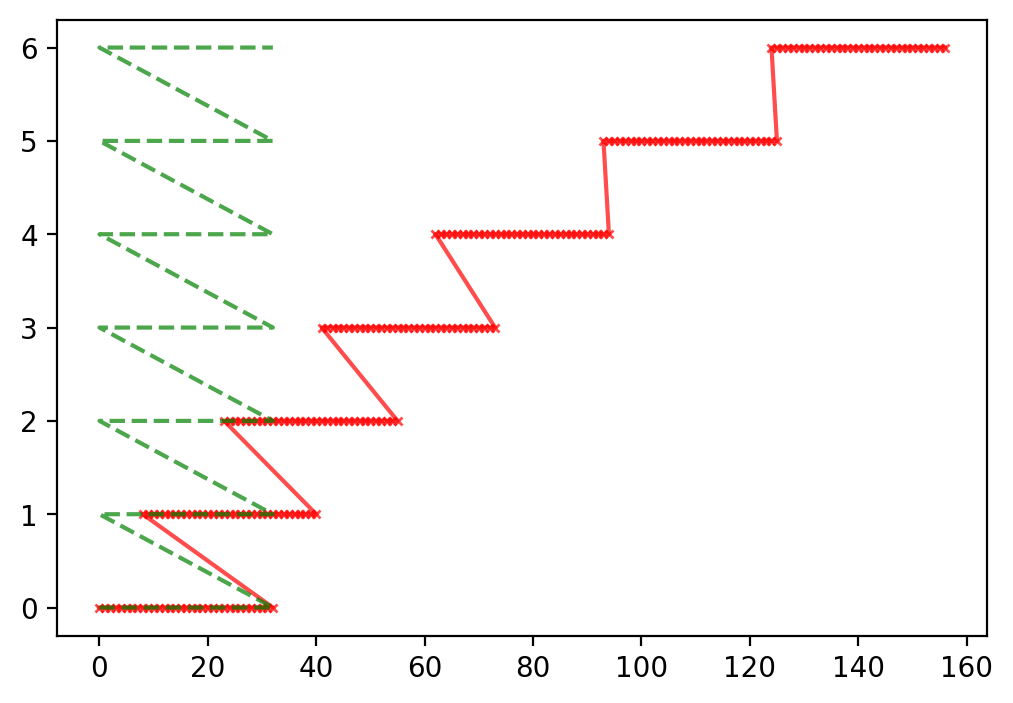

In [15]:
fig = plt.figure(dpi=200, figsize=(6,4))

# plt.semilogy(history['epoch'], history['test_loss'], '-og', markersize=3.0, alpha=.7)
plt.plot(history['epoch'], history['fit_number'], '-xr', markersize=3.0, alpha=.7)
plt.plot(history['fit_epoch'], history['fit_number'], '--g', markersize=3.0, alpha=.7)


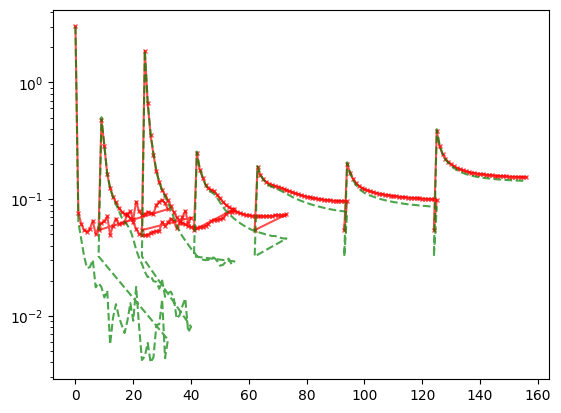

In [19]:
plt.semilogy(history['epoch'], history['test_loss'], '-xr', markersize=3.0, alpha=.7)
plt.semilogy(history['epoch'], history['trained_loss'], '--g', markersize=3.0, alpha=.7)

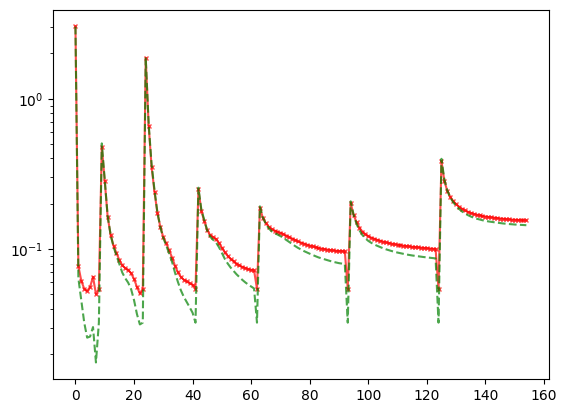

In [20]:
retained = history.loc[history["retained"] == True]
plt.semilogy(retained['epoch'], retained['test_loss'], '-xr', markersize=3.0, alpha=.7)
plt.semilogy(retained['epoch'], retained['trained_loss'], '--g', markersize=3.0, alpha=.7)

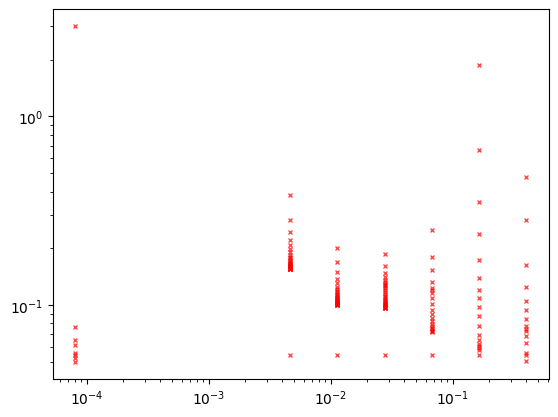

In [30]:
retained = history.loc[history["retained"] == True]
plt.loglog((1 + retained['masked_parameter_count']) / retained['free_parameter_count'], retained['test_loss'], 'xr', markersize=3.0, alpha=.7)

[[  8   9  10  11  12  13  16  19  24  30  40  23  23  24  25  26  27  28
   31  34  39  45  55  41  41  42  43  44  45  46  49  52  57  63  73  62
   62  63  64  65  66  67  70  73  78  84  94  93  93  94  95  96  97  98
  101 104 109 115 125 124 124 125 126 127 128 129 132 135 140 146 156 155]
 [  1   1   1   1   1   1   1   1   1   1   1   1   2   2   2   2   2   2
    2   2   2   2   2   2   3   3   3   3   3   3   3   3   3   3   3   3
    4   4   4   4   4   4   4   4   4   4   4   4   5   5   5   5   5   5
    5   5   5   5   5   5   6   6   6   6   6   6   6   6   6   6   6   6]
 [  0   1   2   3   4   5   8  11  16  22  32  15   0   1   2   3   4   5
    8  11  16  22  32  18   0   1   2   3   4   5   8  11  16  22  32  21
    0   1   2   3   4   5   8  11  16  22  32  31   0   1   2   3   4   5
    8  11  16  22  32  31   0   1   2   3   4   5   8  11  16  22  32  31]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   1   0   0  

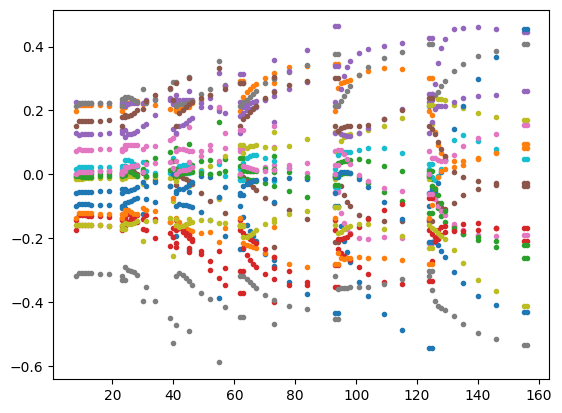

In [47]:
import h5py as h5
import hdf5plugin


# scp eagle:/projects/modularai/dmp/dmp/model_data/c1a3792d-c30d-4b55-9ca4-d1bbcc59518c.h5 .
dmp_path = '/home/ctripp/dmp/dmp/'
model_data_dir = os.path.join(dmp_path, "model_data")
checkpoint_path = os.path.join(model_data_dir, f'c1a3792d-c30d-4b55-9ca4-d1bbcc59518c.h5')
with h5.File(checkpoint_path, "r") as h5_file:
    (
        epoch_dataset,
        parameter_dataset,
        optimizer_datasets,
    ) = model_serialization.get_datasets_from_model_file(h5_file, None)

    global_epoch = epoch_dataset[0,:]
    fit_number = epoch_dataset[1,:]
    fit_epoch = epoch_dataset[2,:]
    epoch_marker = epoch_dataset[3,:]

    for i in range(1,20):
        plt.plot(epoch_dataset[0,:], parameter_dataset[i,:], '.')

    print(epoch_dataset[:,:])


In [46]:
print(epoch_dataset[:,:])

RuntimeError: Unable to synchronously get dataspace (invalid dataset identifier)

In [48]:
with h5.File(checkpoint_path, "r") as h5_file:
    (
        epoch_dataset,
        parameter_dataset,
        optimizer_datasets,
    ) = model_serialization.get_datasets_from_model_file(h5_file, None)

    epoch = TrainingEpoch(epoch_dataset[0,0],
                          epoch_dataset[1,0],
                          epoch_dataset[2,0],
                          epoch_dataset[3,0],)

model = experiment._make_model_from_network(network, metrics)
model_serialization.load_parameters(
        model.network.structure,
        model.keras_network.layer_to_keras_map,
        None,
        checkpoint_path,
        epoch,
        load_mask=True,
    )

0: [] -> (<class 'dmp.layer.input.Input'>: 0, (28, 28, 1), "dmp_8") -> [1]
1: [0] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 156, (28, 28, 6), 5x5, s: 1x1, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [2]
2: [1] -> (<class 'dmp.layer.max_pool.MaxPool'>: 0, (14, 14, 6), s: 2x2) -> [3]
3: [2] -> (<class 'dmp.layer.dense_conv.DenseConv'>: 2416, (10, 10, 16), 5x5, s: 1x1, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [4]
4: [3] -> (<class 'dmp.layer.max_pool.MaxPool'>: 0, (5, 5, 16), s: 2x2) -> [5]
5: [4] -> (<class 'dmp.layer.flatten.Flatten'>: 0, (400,), ) -> [6]
6: [5] -> (<class 'dmp.layer.dense.Dense'>: 48120, (120,), x120, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [7]
7: [6] -> (<class 'dmp.layer.dense.Dense'>: 10164, (84,), x84, relu, kc:"<class 'dict'>: {'class': 'ParameterMask'}") -> [8]
8: [7] -> (<class 'dmp.layer.dense.Dense'>: 850, (10,), x10, softmax, kc:"<class 'NoneType'>: None") -> []
0: [] -> (<class 'dmp.layer.input.Input'>: 0,

TrainingEpoch(epoch=8, fit_number=1, fit_epoch=0, marker=0, sequence_number=0)

In [50]:
for layer in model.network.structure.layers:
    print(layer)

In [56]:
model.keras_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dmp_8 (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 dmp_7 (Conv2D)              (None, 28, 28, 6)         156       
                                                                 
 dmp_6 (MaxPooling2D)        (None, 14, 14, 6)         0         
                                                                 
 dmp_5 (Conv2D)              (None, 10, 10, 16)        2416      
                                                                 
 dmp_4 (MaxPooling2D)        (None, 5, 5, 16)          0         
                                                                 
 dmp_3 (Flatten)             (None, 400)               0         
                                                                 
 dmp_2 (Dense)               (None, 120)               48120 

 dmp_1 (Dense)               (None, 84)                10164     
                                                                 
 dmp_0 (Dense)               (None, 10)                850       
                                                                 
Total params: 61706 (241.04 KB)
Trainable params: 61706 (241.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
import tensorflow.keras as keras
for layer in model.network.structure.layers:
    layer_info = model.keras_network.layer_to_keras_map.get(layer, None)
    if layer_info is None:
        continue

    keras_layer = layer_info.keras_layer
    if keras_layer is None or not isinstance(keras_layer, keras.layers.Layer):
        continue

    for i, variable in enumerate(keras_layer.variables):  # type: ignore
        print(f'layer:{layer} variable {i} with name {variable.name} and shape {variable.shape}')

layer:<dmp.layer.dense.Dense object at 0x7fe64c287fa0> variable 0 with name dmp_0/kernel:0 and shape (84, 10)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287fa0> variable 1 with name dmp_0/bias:0 and shape (10,)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287eb0> variable 0 with name dmp_1/kernel:0 and shape (120, 84)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287eb0> variable 1 with name dmp_1/bias:0 and shape (84,)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287f10> variable 0 with name dmp_2/kernel:0 and shape (400, 120)
layer:<dmp.layer.dense.Dense object at 0x7fe64c287f10> variable 1 with name dmp_2/bias:0 and shape (120,)
layer:<dmp.layer.dense_conv.DenseConv object at 0x7fe64c287760> variable 0 with name dmp_5/kernel:0 and shape (5, 5, 6, 16)
layer:<dmp.layer.dense_conv.DenseConv object at 0x7fe64c287760> variable 1 with name dmp_5/bias:0 and shape (16,)
layer:<dmp.layer.dense_conv.DenseConv object at 0x7fe64c287d60> variable 0 with name dmp_7/kernel:0 and shape (5,

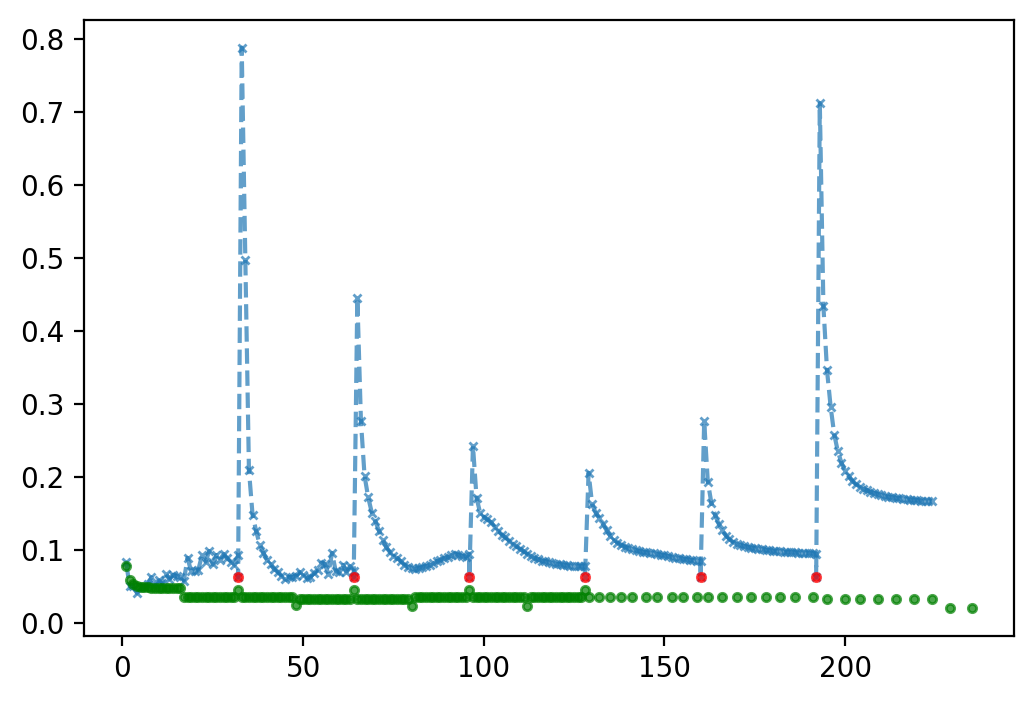

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))

plt.plot(history['epoch'], history['test_loss'], '--x', markersize=3.0, alpha=.7)
new_iterations = history[history['model_epoch'] == 0]
plt.plot(by_epoch['epoch'], by_epoch['test_loss_cmin_quantile_50'], 'og', markersize=3.0, alpha=.7)

plt.plot(new_iterations['epoch'], new_iterations['test_loss'], 'or', markersize=3.0, alpha=.7)


In [ ]:
history.columns

Index(['test_loss', 'trained_categorical_crossentropy', 'trained_accuracy',
       'train_categorical_crossentropy', 'free_parameter_count',
       'train_accuracy', 'retained', 'validation_categorical_crossentropy',
       'masked_parameter_count', 'validation_accuracy', 'trainms_ms',
       'trained_ms', 'train_loss', 'test_ms', 'model_epoch', 'epoch',
       'validation_loss', 'seed_number', 'test_accuracy', 'model_number',
       'test_categorical_crossentropy', 'trained_loss', 'epoch_startms_ms'],
      dtype='object')

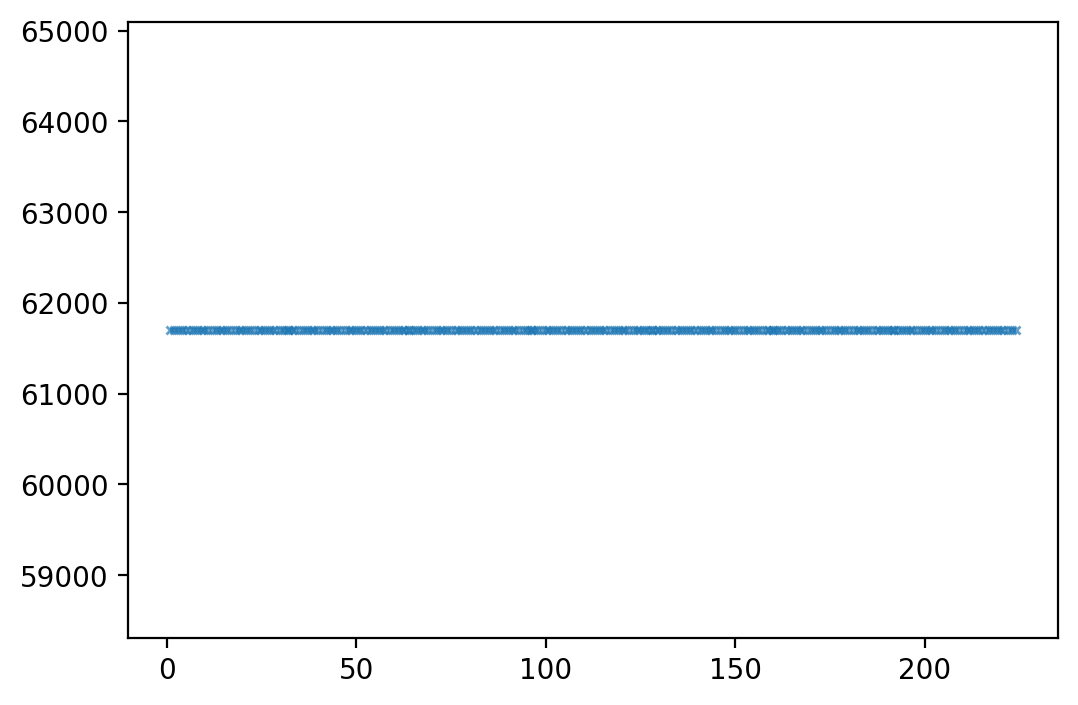

In [ ]:
fig = plt.figure(dpi=200, figsize=(6,4))

plt.plot(history['epoch'], history['free_parameter_count'], '--x', markersize=3.0, alpha=.7)


In [ ]:

credentials = jobqueue.load_credentials('dmp')
with ConnectionManager(credentials) as connection:
    with connection.cursor(binary=True) as cursor:
        query = psycopg.sql.SQL("""
SELECT
    by_epoch
FROM
    experiment2 e
WHERE TRUE
    AND e.experiment_id = 'b0d415cf-f228-c439-0480-3337c543c2e4'
LIMIT 1;
""")

        cursor.execute(query, binary=True)
        row = cursor.fetchone()
        with io.BytesIO(row[0]) as buffer:
            by_epoch = pyarrow.parquet.read_table(
                pyarrow.PythonFile(buffer, mode='r')).to_pandas()


by_epoch.describe()
by_epoch

,epoch,count,model_epoch_quantile_0,model_epoch_quantile_25,model_epoch_quantile_50,model_epoch_quantile_75,model_epoch_quantile_100,trained_categorical_crossentropy_quantile_0,trained_categorical_crossentropy_quantile_25,trained_categorical_crossentropy_quantile_50,...,test_accuracy_cmax_quantile_0,test_accuracy_cmax_quantile_25,test_accuracy_cmax_quantile_50,test_accuracy_cmax_quantile_75,test_accuracy_cmax_quantile_100,validation_accuracy_cmax_quantile_0,validation_accuracy_cmax_quantile_25,validation_accuracy_cmax_quantile_50,validation_accuracy_cmax_quantile_75,validation_accuracy_cmax_quantile_100
0,1,8,1.0,1.0,1.0,1.0,1.0,0.060437,0.061399,0.066523,...,0.9734,0.973925,0.97625,0.977575,0.9798,0.974000,0.975571,0.976571,0.977286,0.980571
1,2,8,2.0,2.0,2.0,2.0,2.0,0.039023,0.039946,0.041580,...,0.9762,0.980350,0.98225,0.982875,0.9843,0.980000,0.981071,0.981429,0.982143,0.985143
2,3,8,3.0,3.0,3.0,3.0,3.0,0.028624,0.030501,0.035552,...,0.9810,0.981500,0.98280,0.983900,0.9866,0.980857,0.981643,0.983000,0.984071,0.989429
3,4,8,4.0,4.0,4.0,4.0,4.0,0.019772,0.025258,0.027370,...,0.9812,0.981675,0.98450,0.985625,0.9885,0.980857,0.983214,0.983857,0.986857,0.989429
4,5,8,5.0,5.0,5.0,5.0,5.0,0.017522,0.022112,0.024034,...,0.9816,0.984450,0.98495,0.985650,0.9885,0.980857,0.983929,0.985429,0.987071,0.989429
5,6,8,6.0,6.0,6.0,6.0,6.0,0.016902,0.019114,0.019577,...,0.9819,0.984825,0.98520,0.986550,0.9885,0.984000,0.984786,0.985571,0.987071,0.989429
6,7,8,7.0,7.0,7.0,7.0,7.0,0.014243,0.016146,0.017878,...,0.9851,0.985725,0.98655,0.988050,0.9885,0.984000,0.985143,0.986000,0.987214,0.989429
7,8,8,8.0,8.0,8.0,8.0,8.0,0.010488,0.012256,0.017983,...,0.9851,0.986250,0.98745,0.988500,0.9888,0.984000,0.985143,0.986143,0.987214,0.989714
8,9,8,9.0,9.0,9.0,9.0,9.0,0.010544,0.011973,0.016272,...,0.9851,0.986250,0.98775,0.988500,0.9891,0.984000,0.985143,0.986143,0.987214,0.990000
9,10,8,10.0,10.0,10.0,10.0,10.0,0.008422,0.011188,0.012371,...,0.9859,0.986800,0.98775,0.988500,0.9897,0.984000,0.985143,0.986714,0.988643,0.990000


In [ ]:
df.columns

Index(['experiment_id', 'old_experiment_id', 'experiment_attrs', 'run_id',
       'job_id', 'slurm_job_id', 'run_timestamp', 'seed', 'task_version',
       'num_nodes',
       ...
       'precision', 'worker_id', 'record_model', 'record_times',
       'python_version', 'record_metrics', 'tensorflow_version',
       'tensorflow_strategy', 'record_post_training_metrics',
       'make_batch_optimizer_butter_growth_eagle_gpu_1'],
      dtype='object', length=105)

In [ ]:
df['run_history'].iloc[0]['train_loss']


0      1.247540
1      0.898057
2      0.847315
3      0.850349
4      0.847144
         ...   
145    0.225552
146    0.213775
147    0.213580
148    0.213284
149    0.210847
Name: train_loss, Length: 150, dtype: float32

In [ ]:
run_df = df['run_history'].iloc[0]
run_df['trained_loss'] - run_df['train_loss']

0      0.000000
1     -0.047707
2      0.003034
3      0.000000
4     -0.001494
         ...   
145    0.026551
146   -0.015600
147   -0.015426
148   -0.008199
149    0.011152
Length: 150, dtype: float32